In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import UnitaryGate
from qiskit.visualization import plot_histogram
from scipy.linalg import expm

def plot_images(df, n_images=5, img_size=28):
    labels = df[0].values
    pixels = df.iloc[:, 1:].values

    plt.figure(figsize=(15, 3))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(pixels[i].reshape(img_size,img_size), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

def reduce_to_nxn(df, n):
    labels = df[0].astype(int).values  # Ensure labels are int
    pixels = df.iloc[:, 1:].values
    images_nxn = np.zeros((len(pixels), n * n))
    for i, img in enumerate(pixels):
        img_2d = img.reshape(28, 28)
        img_nxn = resize(img_2d, (n, n), anti_aliasing=True)
        images_nxn[i] = img_nxn.flatten()
    # Return as DataFrame with int labels in first column
    result = pd.DataFrame(np.column_stack([labels, images_nxn]))
    result[0] = result[0].astype(int)
    return result

def normalize_pixels_01(df):
    """
    Normalize all pixels in the DataFrame to values between 0 and 1.
    Assumes column 0 is the label and the rest are pixels.
    The maximum is computed from all pixel columns.
    """
    df_norm = df.copy()
    max_val = df_norm.iloc[:, 1:].values.max()
    if max_val == 0:
        return df_norm
    df_norm.iloc[:, 1:] = df_norm.iloc[:, 1:] / max_val
    return df_norm

def normalize_by_norm(df):
    """
    Normalize each set of pixels by dividing by the L2 norm of its own values.
    Assumes column 0 is the label and the rest are pixels.
    """
    df_norm = df.copy()
    pix = df_norm.iloc[:, 1:].values
    norms = np.linalg.norm(pix, axis=1, keepdims=True)
    # Avoid division by zero
    norms[norms == 0] = 1
    df_norm.iloc[:, 1:] = pix / norms
    return df_norm

def get_balanced_subset(Data, n=75):
    """
    Select a balanced subset of n samples per class (0 and 1) from a pandas DataFrame.
    
    Args:
        Data (pd.DataFrame): DataFrame where column 0 is the label.
        n (int): Number of samples per class.
    
    Returns:
        pd.DataFrame: Balanced subset.
    """
    class_1 = Data[Data[0] == 1]
    class_0 = Data[Data[0] == 0]

    if len(class_1) < n or len(class_0) < n:
        raise ValueError("Not enough elements in some class.")

    subset_1 = class_1.sample(n=n, replace=False, random_state=None)
    subset_0 = class_0.sample(n=n, replace=False, random_state=None)

    subset = pd.concat([subset_1, subset_0]).sample(frac=1).reset_index(drop=True)
    return subset

def get_hermitian_matrix(upper_values, n):
    """
    Create an nxn Hermitian matrix from the upper triangular values and the main diagonal. Only real values on the diagonal.
    
    Args:
        upper_values (list): List of upper triangular values (including the main diagonal).
        n (int): Matrix dimension (nxn).
    
    Returns:
        np.ndarray: Hermitian matrix nxn.
    """
    matrix = np.zeros((n, n), dtype=complex)
    idx = 0
    for i in range(n):
        matrix[i, i] = upper_values[idx]  # Main diagonal
        idx += 1
        for j in range(i+1, n):
            matrix[i, j] = upper_values[idx]+upper_values[idx+1]*1j
            matrix[j, i] = np.conjugate(matrix[i, j])  # Make the matrix Hermitian
            idx += 2
    return matrix

def get_tree_V1(Theta, n_gates=7):
    """
    Generate a list of unitary gates from the values of Theta.

    Args:
        Theta (numpy.ndarray): Array of values to build Hermitian matrices.
        n_gates (int): Number of unitary gates to generate (default 3).

    Returns:
        list: List of unitary gates.
    """
    gates = []
    for i in range(n_gates):
        start = i * 16
        hermitian = get_hermitian_matrix(Theta[start:start + 16], 4)
        gates.append(UnitaryGate(expm(1j * hermitian)))
    return gates

def get_circuit(array, Tree):
    """
    Create a quantum circuit based on the image and the tree gates.
    
    Args:
        array (list): Image array.
        Tree (list): Tree gates.
    
    Returns:
        QuantumCircuit: Created quantum circuit.
    """
    q = QuantumRegister(8, 'q')
    c = ClassicalRegister(1, 'c')
    qc = QuantumCircuit(q, c)
    qc.prepare_state(array, q)
    qc.barrier()
    qc.append(Tree[0], q[0:2])
    qc.append(Tree[1], q[2:4])
    qc.append(Tree[2], q[4:6])
    qc.append(Tree[3], q[6:8])
    qc.barrier()
    qc.append(Tree[4], [q[1], q[3]])
    qc.append(Tree[5], [q[5], q[7]])
    qc.barrier()
    qc.append(Tree[6], [q[3], q[7]])
    qc.measure(q[7], c)
    return qc

def get_accuracy(df, backend, Tree, N_Shots, print_out=False):
    """
    Calculate the accuracy for a set of images.
    
    Args:
        df
        backend: Quantum backend to use.
        Tree (list): List of unitary gates.
        N_Shots (int): Number of shots for the simulation.
    
    Returns:
        float: Accuracy.
        ndarray: Array of file, correct label and predicted label.
    """
    correct = 0
    log = []
    length = df.shape[0]
    labels = df[0].astype(int).values
    pixels = df.iloc[:, 1:].values

    for i in range(length):
        qc = get_circuit(pixels[i], Tree)
        label = labels[i]
        transpiled_circuit = transpile(qc, backend=backend, optimization_level=1)
        job = backend.run(transpiled_circuit, shots=N_Shots)
        result = job.result()
        counts = result.get_counts()
        if str(label) == max(counts, key=counts.get):
            correct += 1
        log.append([label, counts, pixels[i]])

        if print_out:
            print("Num", i, label, counts, max(counts, key=counts.get))
    return correct / length, log

def get_cost(counts, label, shots):
    return (1 - counts[str(label)] / shots)

def get_total_error(df, backend, Tree, N_Shots):
    """
    Calculate the total error for a set of images.
    
    Args:
        df
        backend: Quantum backend to use.
        Tree (list): List of unitary gates.
        N_Shots (int): Number of shots for the simulation.
    
    Returns:
        float: Total error.
        ndarray: Array of file, correct label and predicted label.
    """
    total_error = 0
    log = []
    length = df.shape[0]
    labels = df[0].astype(int).values
    pixels = df.iloc[:, 1:].values

    for i in range(length):
        qc = get_circuit(pixels[i], Tree)
        label = labels[i]
        transpiled_circuit = transpile(qc, backend=backend, optimization_level=1)
        job = backend.run(transpiled_circuit, shots=N_Shots)
        result = job.result()
        counts = result.get_counts()
        total_error += get_cost(counts, label, N_Shots)
        log.append([label, counts, pixels[i]])
    return total_error / length, log

def SPSA(cost_fn, theta_0, a, b, A, s, t, gamma, n, M, train_set, test_set, backend, N_Shots=100):
    """
    Simultaneous Perturbation Stochastic Approximation (SPSA) algorithm for optimizing a quantum circuit.
    Args:
        cost_fn (function): Function to compute the cost.
        theta_0 (np.ndarray): Initial parameters for the quantum circuit.
        a (float): Initial step size.
        b (float): Initial perturbation size.
        A (float): Constant for step size decay.
        s (float): Exponent for step size decay.
        t (float): Exponent for perturbation decay.
        gamma (float): Momentum factor.
        n (int): Number of samples per class for balanced subset.
        M (int): Number of iterations.
        train_set (pd.DataFrame): Training dataset.
        test_set (pd.DataFrame): Testing dataset.
        backend: Quantum backend to use.
        N_Shots (int): Number of shots for the simulation.
    Returns:
        np.ndarray: Optimized parameters.
        list: Real performance at each iteration.
        list: List of theta values at each iteration.
        list: List of costs at each iteration.
    """
    theta = theta_0.copy()
    real_performance = []
    thetas = []
    costs = []
    v_new = np.zeros(len(theta_0))
    v_old = np.zeros(len(theta_0))
    for k in range(0, M):
        v_old = v_new.copy()
        alpha_k = a / (k + 1 + A) ** s
        beta_k = b / (k + 1) ** t
        delta = np.random.choice([-1, 1], size=len(theta))
        subset = get_balanced_subset(train_set, n)
        y_plus, _ = cost_fn(subset, backend, get_tree_V1(theta + alpha_k * delta), N_Shots)
        y_minus, _ = cost_fn(subset, backend, get_tree_V1(theta - alpha_k * delta), N_Shots)
        g_k = (y_plus - y_minus) / (2 * alpha_k)
        v_new = gamma * v_old - beta_k * g_k * delta
        theta += v_new
        real_performance.append(get_accuracy(get_balanced_subset(test_set, n), backend, get_tree_V1(theta), N_Shots)[0])
        thetas.append(theta.copy())
        costs.append((y_plus + y_minus) / 2)
        print(f"Iteration {k}: Cost_plus = {y_plus}, Cost_minus = {y_minus}, cost = {costs[-1]}, gradient = {g_k}, performance = {real_performance[-1]}, alpha = {alpha_k}, beta = {beta_k}")
    return theta, real_performance, thetas, costs

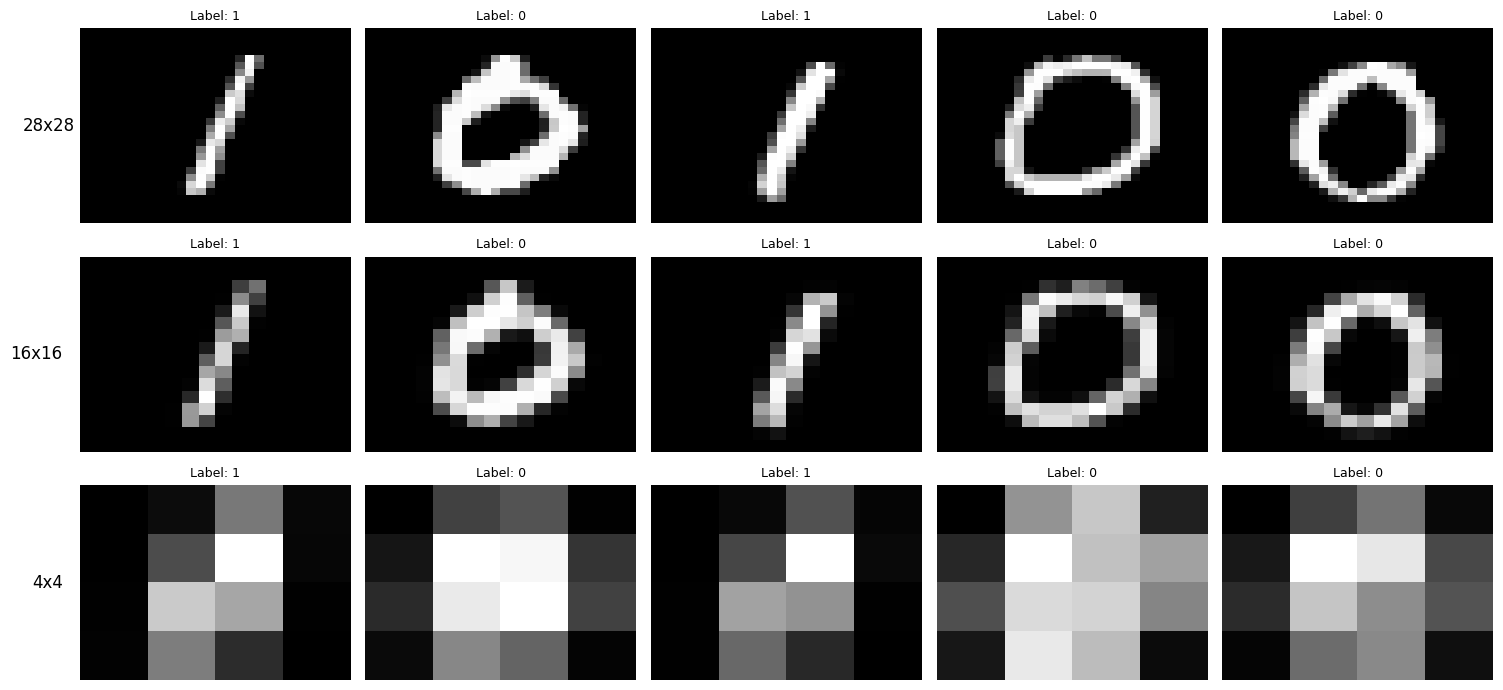

In [2]:
# 1. Load CSV (no headers, first column=label)
df = pd.read_csv('mnist_test.csv', header=None)

# 2. Filter only 0s and 1s
df = df[(df[0] == 0) | (df[0] == 1)]

df_16x16 = reduce_to_nxn(df,16)
df_4x4 = reduce_to_nxn(df,4)


fig, axes = plt.subplots(3, 5, figsize=(15, 7))
sizes = [(df, 28), (df_16x16, 16), (df_4x4, 4)]
titles = ["28x28", "16x16", "4x4"]

for row, (data, img_size) in enumerate(sizes):
    labels = data[0].values
    pixels = data.iloc[:, 1:].values
    for col in range(5):
        ax = axes[row, col]
        ax.imshow(pixels[col].reshape(img_size, img_size), cmap='gray', aspect='auto')
        if col == 0:
            ax.set_ylabel(f"{img_size}x{img_size}", fontsize=12)
        ax.set_title(f"Label: {labels[col]}", fontsize=9)
        ax.axis('off')
    # Add a row title spanning all columns
    axes[row, 0].annotate(
        titles[row],
        xy=(0, 0.5),
        xytext=(-axes[row, 0].yaxis.labelpad - 0, 0),
        xycoords=axes[row, 0].yaxis.label,
        textcoords='offset points',
        size='large',
        ha='left',
        va='center',
        rotation=0,
    )

plt.tight_layout()
plt.show()


In [6]:
print(list(df_16x16.iloc[0]))

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.41071302212347e-22, 2.4903478962789835e-20, 4.6428306024782463e-20, 4.045963423939247e-22, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.6963452064921e-20, 6.404026341005264e-18, 1.1688757003995604e-17, 1.0166357050500949e-19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.243831516919045e-26, 1.6029501901379702e-19, 1.439663684049708e-17, 6.63728731257089e-18, 3.4699830027085766e-20, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.5885018340814746e-24, 2.7004513185795457e-18, 2.410264469839954e-17, 1.9021246767152686e-18, 3.052043638949593e-24, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.910422062581672e-21, 8.892358394723209e-18, 2.075543571535468e-17, 2.4510292065548194e-19, 2.722573081135459e-25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.8770561286854305e-30, 1.5895878357643953e-19, 1.61010192900447

/home/ubu-tercero-el-cruel/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: /home/ubu-tercero-el-cruel/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/styles/iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


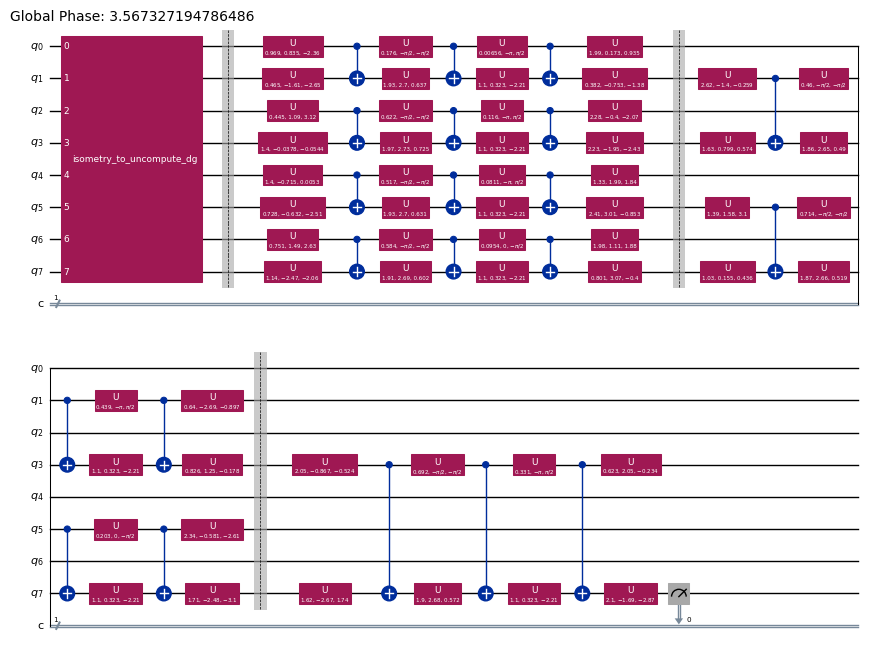

In [5]:
norm_16x16 = normalize_by_norm(df_16x16)
qc= get_circuit(norm_16x16.iloc[0, 1:].values, get_tree_V1(np.random.rand(112)))
qc.decompose().draw('mpl', scale=0.5, style='iqx')

In [42]:
test_df = pd.read_csv('mnist_test.csv', header=None)
train_df = pd.read_csv('mnist_train.csv', header=None)
# 2. Filter only 0s and 1s
test_df = test_df[(test_df[0] == 0) | (test_df[0] == 1)]
train_df = train_df[(train_df[0] == 0) | (train_df[0] == 1)]


# Reduce and display images
test_df_16x16 = reduce_to_nxn(test_df,16)
train_df_16x16 = reduce_to_nxn(train_df,16)

test_df_16x16= normalize_by_norm(test_df_16x16)
train_df_16x16 = normalize_by_norm(train_df_16x16)


sub_train = get_balanced_subset(train_df_16x16, 75)
sub_test = get_balanced_subset(test_df_16x16, 75)

In [43]:
N_shots = 1000

Theta = np.random.uniform(-0.5, 0.5, 112)  # 7 * 16 valores para las matrices hermíticas
Tree=get_tree_V1(Theta)

backend = Aer.get_backend('qasm_simulator')


cost, log = get_total_error(sub_train,backend,Tree,N_shots)
print("Coste inicial: ", cost)
cost_test, log_test = get_accuracy(sub_test, backend, Tree, N_shots)
print("Rendimineto test: ", cost_test)

Coste inicial:  0.45192666666666675
Rendimineto test:  0.5933333333333334


In [44]:
N_shots = 1000 # N_S
a=0.05 # a
b=0.5 # c
A=5 # A
s=0.101 # alpha
t=0.6 # gamma
gamma=0.05 # lambda
n=75 # K/2
M= 30 #M

new_theta, accuracy, Thetalog, costs = SPSA(get_total_error, Theta, a, b, A, s, t, gamma, n, M, train_df_16x16, test_df_16x16, backend, N_shots)

Iteration 0: Cost_plus = 0.46077999999999986, Cost_minus = 0.4627400000000002, cost = 0.46176000000000006, gradient = -0.023488178983859187, performance = 0.5466666666666666, alpha = 0.0417231153029624, beta = 0.5
Iteration 1: Cost_plus = 0.45169333333333317, Cost_minus = 0.46768666666666625, cost = 0.4596899999999997, gradient = -0.19466769696841044, performance = 0.6333333333333333, alpha = 0.04107854970906752, beta = 0.3298769776932236
Iteration 2: Cost_plus = 0.4627066666666666, Cost_minus = 0.44586666666666674, cost = 0.45428666666666667, gradient = 0.20775628739591742, performance = 0.76, alpha = 0.04052825599426546, beta = 0.2586409289858933
Iteration 3: Cost_plus = 0.4593333333333331, Cost_minus = 0.45680666666666647, cost = 0.45806999999999976, gradient = 0.03154470311463224, performance = 0.7733333333333333, alpha = 0.04004898472946174, beta = 0.21763764082403106
Iteration 4: Cost_plus = 0.4491066666666665, Cost_minus = 0.4496333333333334, cost = 0.44936999999999994, gradient

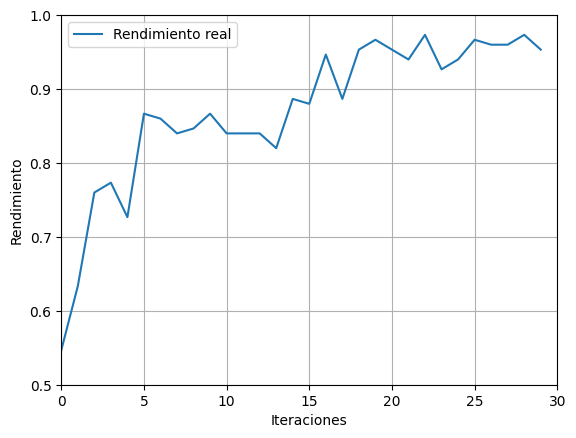

In [51]:
plt.plot(accuracy, label='Rendimiento real')
plt.xlabel('Iteraciones')
plt.ylabel('Rendimiento')
plt.legend()
plt.axis([0, M, 0.5, 1])
plt.grid(True)

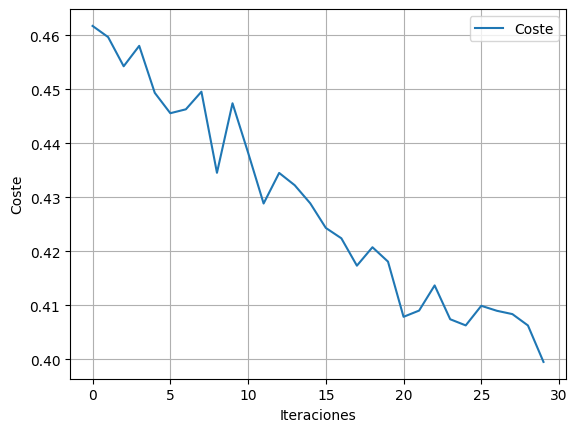

In [55]:
plt.plot(costs, label='Coste')
plt.xlabel('Iteraciones')
plt.ylabel('Coste')
plt.legend()
plt.grid(True)

In [48]:
np.savetxt('V1_16x16_amplitude(new_theta).txt', new_theta)
np.savetxt('V1_16x16_amplitude(accuracy).txt', accuracy)
np.savetxt('V1_16x16_amplitude(Thetalog).txt', Thetalog)
